# Real-time optimization with Modifier Adapation using Gaussian Processes
## DE x SQP x Hybrid approach


In [ ]:
# First, let's import some necessary stuff
%load_ext autoreload
%autoreload 2

import matplotlib.font_manager
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
# plt.rc('font', family='serif', serif='Times')
#plt.rc('xtick', labelsize=8)
#plt.rc('ytick', labelsize=8)
#plt.rc('axes', labelsize=8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"


# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from bussineslogic.rto_data import RTODataModel
from optimization.utils import build_F, convert_ivp_results
from model.process.semi_batch import SemiBatchReactor

md_sbai = RTODataModel('/mnt/d/rto_data/rto_sbai_experiments.db')
# The real plant optimum
# Load the real model to generate samples
model_ideal = SemiBatchReactor()
u_plant = [18.4427644, 0.00110823777, 227.792418]
f_plant = -0.5085930760109818


## Data Preparation

In [ ]:
# Now, let's load the results data
# Then load the results
base_id = 1
all_results_exact_klast = pd.DataFrame(md_sbai.get_rto_experiment_results_by_id(base_id), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])

In [18]:
# After that, preprocess the DB data
def aggfunc(x):
    return x
# Define a helper function to perform the calculations
def pre_process_results(all_results):
    # Transform the data
    all_results_pv = pd.pivot_table(all_results, values='value', index=['run.id','iteration','rto.type','run.status'], columns=['var_name'], aggfunc=aggfunc)
    all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)
    
    # remove the suffix
    all_results_pv['rto.type'] = all_results_pv['rto.type'].apply(lambda x: x.split('-')[2]).map({'de_sqp_hybrid': 'Hybrid', 'slsqp_scipy': 'SQP', 'de_scipy_best1bin': 'DE' })

    # Convert the values
    all_results_pv[['cost_model','cost_real','fobj_modifier', 'opt_time', 'n_fev']] = all_results_pv[['cost_model','cost_real','fobj_modifier','opt_time','n_fev']].astype('float')

    # Extract some variables
    all_results_pv['g_0'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[1])) 

    all_results_pv['tm'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['Fs'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['ts'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[2])) 

    # kpis
    all_results_pv['du'] = all_results_pv[['tm','Fs','ts']].apply(lambda x: np.linalg.norm(100 * (x - u_plant)/u_plant), axis=1)
    all_results_pv['dPhi'] = all_results_pv[['cost_real']].apply(lambda x: 100 * np.abs((x - f_plant)/f_plant))
    all_results_pv['g_Cb_tf'] = all_results_pv['g_0'].apply(lambda x: 'Not violated' if x <= 0.025 else 'Violated')
    all_results_pv['g_Cd_tf'] = all_results_pv['g_1'].apply(lambda x: 'Not violated' if x <= 0.15 else 'Violated')

    return all_results_pv

In [19]:
# Now apply the transformation
results_all = pre_process_results(all_results_exact_klast)
results_all.head()

var_name,run.id,iteration,rto.type,run.status,cost_model,cost_real,fobj_modifier,g_model,g_modifiers,g_real,...,g_1_model,g_0_modifiers,g_1_modifiers,tm,Fs,ts,du,dPhi,g_Cb_tf,g_Cd_tf
0,1,0,SQP,initialization,-0.509582,-0.391486,0.118096,"0.0528683446183665,0.15197292073483287","-0.03008301507254786,-0.0839936656330884","0.02278532954581864,0.06797925510174448",...,0.151973,-0.030083,-0.083994,11.594066,0.000572,236.673777,61.122004,23.025655,Not violated,Not violated
1,2,1,SQP,initialization,-0.498627,-0.386707,0.111920,"0.03226120794383668,0.1425084189883919","-0.022763226786596757,-0.07936767698244432","0.009497981157239925,0.06314074200594758",...,0.142508,-0.022763,-0.079368,9.711483,0.000579,221.671548,67.266773,23.965328,Not violated,Not violated
2,3,0,DE,initialization,-0.509582,-0.391486,0.118096,"0.0528683446183665,0.15197292073483287","-0.03008301507254786,-0.0839936656330884","0.02278532954581864,0.06797925510174448",...,0.151973,-0.030083,-0.083994,11.594066,0.000572,236.673777,61.122004,23.025655,Not violated,Not violated
3,4,0,Hybrid,initialization,-0.509582,-0.391486,0.118096,"0.0528683446183665,0.15197292073483287","-0.03008301507254786,-0.0839936656330884","0.02278532954581864,0.06797925510174448",...,0.151973,-0.030083,-0.083994,11.594066,0.000572,236.673777,61.122004,23.025655,Not violated,Not violated
4,5,1,Hybrid,initialization,-0.498627,-0.386707,0.111920,"0.03226120794383668,0.1425084189883919","-0.022763226786596757,-0.07936767698244432","0.009497981157239925,0.06314074200594758",...,0.142508,-0.022763,-0.079368,9.711483,0.000579,221.671548,67.266773,23.965328,Not violated,Not violated


## Results

In [20]:
# helper function for plotting
def plot_results(data, y, ylabel, title='', x='iteration', hue='rto.type', style='run.status', estimator=np.mean, ci=95, save=False, err_style='band'):
    width = 5.1667 * 2
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))
    sns.lineplot(data=data, y=y, x=x, style=hue, hue=hue, ax=ax, estimator=estimator, ci=ci, err_style=err_style, palette='Set1', seed=1234)# legend=True)#, dashes=[(1, 1, 1),(3, 3, 3)])
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.get_legend().set_title('')

    if save == True:
        fig.savefig('fig_{}.pdf'.format(y), dpi=300)

    return ax, fig

def plot_all_input_signals(data, ylabel = 'F (mol / L)', y = ['tm','Fs','ts'], hue='rto.type', title='', save=False):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    data_grouped = data_last_iteration.groupby(hue)

    width = 5.1667
    height = width / 1.618
    # Opt results
    sim_opt = model_ideal.simulate(u_plant)    
    F_opt = build_F(sim_opt.t, u_plant)

    fig, ax = plt.subplots(1, len(data_grouped.groups), figsize=(width, height), sharey=True)    
    #fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
    # Set1
    #e41a1c
    #377eb8
    #4daf4a
    #984ea3
    #ff7f00
    #ffff33
    #a65628
    #f781bf
    #999999

    i = 0
    names = ['DE', 'SQP']
    for name, group in data_grouped:
        
        # find max cost index
        u_mean = group[y].mean()
        # Build the input signal F
        #F_mean = build_F(sim_opt.t, u_mean)
        # Plot the input signal
        #ax[i].plot(sim_opt.t, F_mean, 'b--', lw=2)
        ax[i].set_xlabel('Time (min)')
        if(i == 0):
            ax[i].set_ylabel(ylabel)    
        ax[i].set_title(names[i])
        for j in range(group.shape[0]):
            F_i = build_F(sim_opt.t,  group[y].iloc[j,:]) 
            line1, = ax[i].plot(sim_opt.t, F_i, color='#e41a1c', linewidth='1', alpha=0.8, linestyle='dashed')

        line2, = ax[i].plot(sim_opt.t, F_opt, 'k-', lw=2)
        if (i==1):
            ax[i].legend((line2, line1), ('Optimum','k-$th$ experiment'))
            #ax[i].legend(['Optimum','k-$th$ experiment'])
        
        i = i + 1
    if save == True:
        fig.savefig('fig_F(t).pdf', dpi=300)



In [ ]:
# plot the cost distribution at the last iteration
def plot_last_iteration_dist(data, ylabel = '', y = 'dPhi', hue='rto.type', title=''):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    
    width = 5.1667
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))
    
    sns.histplot(data_last_iteration, x=y, hue=hue, kde=True, ax=ax, palette='Set1')

    ax.set_xlabel(ylabel)
    ax.set_title(title)
    fig.show()


In [ ]:
plot_all_input_signals(results_all, save=True)

In [ ]:
display(results_all.groupby(['iteration','rto.type'])['dPhi'].apply(np.mean))

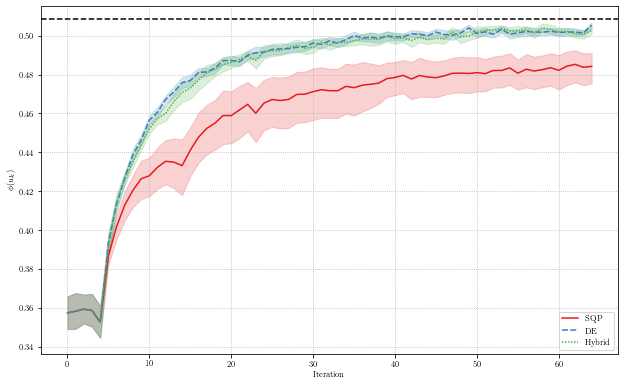

In [32]:
# Plot the convergence results for objective function
neg_mean = lambda x: -np.mean(x)

ax, fig = plot_results(results_all, 'cost_real', '$\phi(u_k)$', estimator=neg_mean, title='Noise: 1%')
ax.axhline(-f_plant, linestyle='--', color='k')
fig.show()

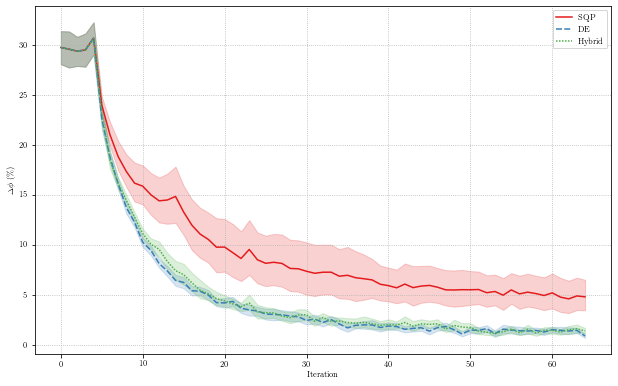

In [21]:
# Plot the convergence results for dPhi
ax, fig = plot_results(results_all, 'dPhi', '$\Delta \phi$ (\%)')
#ax.axhline(0, linestyle='-.', color='k')
#fig.savefig('fig_{}.pdf'.format('dPhi'), dpi=300)
fig.show()



count
rto.type g_Cb_tf            
DE       Not violated   1896
         Violated         54
Hybrid   Not violated   1923
         Violated         27
SQP      Not violated   1795
         Violated        155

count
rto.type g_Cd_tf            
DE       Not violated   1939
         Violated         11
Hybrid   Not violated   1906
         Violated         44
SQP      Not violated   1929
         Violated         21

,mean
rto.type,
DE,390.706667
Hybrid,341.045641
SQP,95.239487


,mean,median,std,min,max
rto.type,,,,,
DE,7.313708,6.543289,2.834069,3.007713,27.384799
Hybrid,6.263225,5.718361,2.331720,2.507146,22.569113
SQP,1.378871,0.411885,7.211381,0.062998,180.065970


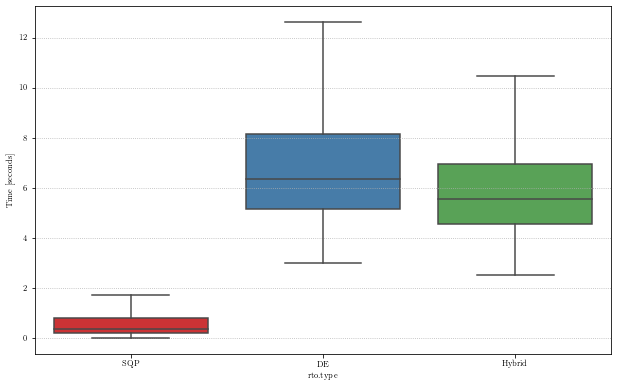

In [24]:
# convergence statistics
display(results_all.groupby(['rto.type', 'g_Cb_tf'])['g_Cb_tf'].agg(['count']))
display(results_all.groupby(['rto.type', 'g_Cd_tf'])['g_Cd_tf'].agg(['count']))
display(results_all.groupby(['rto.type'])['n_fev'].agg(['mean']))
results_all['opt_time'] = results_all['opt_time'].astype('float')
display(results_all[results_all['run.status'] == 'closed-loop'].groupby(['rto.type'])['opt_time'].agg(['mean','median','std', 'min', 'max' ]))
width = 5.1667 * 2
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width, height))
sns.boxplot(y='opt_time', data=results_all, x='rto.type', showfliers=False, ax=ax, palette='Set1')
ax.set_ylabel('Time [seconds]')
fig.show()
#fig.savefig('Fig_opt_time.pdf', dpi=300)


,mean
rto.type,
DE,6.751115
Hybrid,5.781439
SQP,1.272804


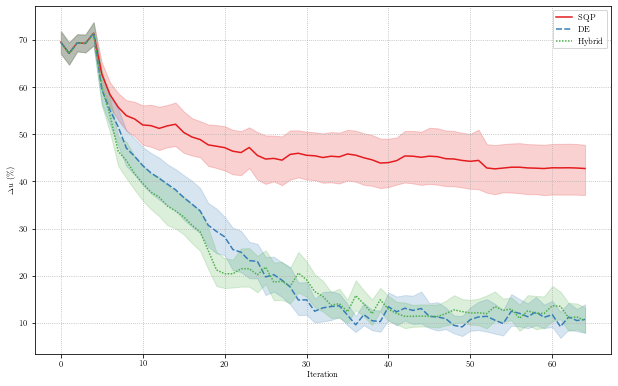

In [25]:
# Plot the convergence results for the input signal difference
display(results_all.groupby(['rto.type'])['opt_time'].agg(['mean']))

ax, fig = plot_results(results_all, 'du', '$\Delta u$ (\%)')
#ax.axhline(0, linestyle='--', color='k')
#fig.savefig('fig_{}.pdf'.format('du'), dpi=300)
fig.show()


ShapiroResult(statistic=0.9172714948654175, pvalue=0.022800644859671593)
ShapiroResult(statistic=0.7114439010620117, pvalue=2.2993194761511404e-06)
ShapiroResult(statistic=0.9591515064239502, pvalue=0.2946355640888214)


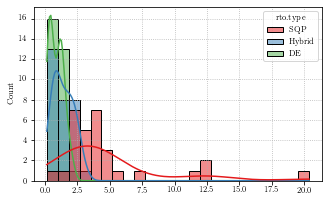

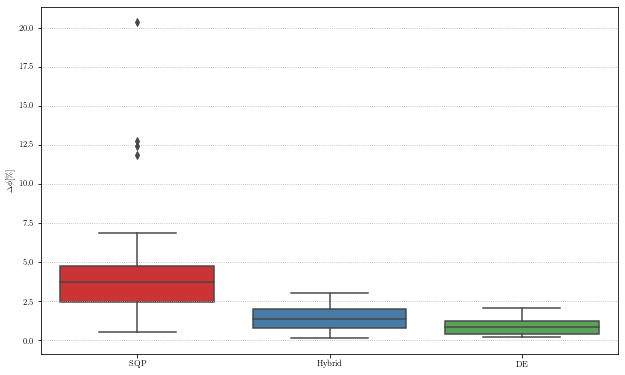

In [28]:
# hypothesis test
plot_last_iteration_dist(results_all)

data_last_iteration = results_all[results_all['iteration'] == max(results_all['iteration'])]

width = 5.1667 * 2
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))
sns.boxplot(data=data_last_iteration, y='dPhi', x='rto.type', palette='Set1', ax=ax)
ax.set_ylabel('$\Delta \phi [\%]$')
ax.set_xlabel('')
#fig.savefig('fig_dPhi_boxplot.pdf', dpi=300)

data_sqp = data_last_iteration[data_last_iteration['rto.type'] == 'SQP']['dPhi']
data_de = data_last_iteration[data_last_iteration['rto.type'] == 'DE']['dPhi']
data_hyb = data_last_iteration[data_last_iteration['rto.type'] == 'Hybrid']['dPhi']

# Check normality
print(stats.shapiro(data_de))
print(stats.shapiro(data_sqp))
print(stats.shapiro(data_hyb))

4.792879762403791    (3.0270587836560185, 6.0728832264582016)
0.8729947365133616    (0.6712224861487543, 1.0659218650974749)
1.3985441659702156    (1.1356735442570496, 1.6814585622353788)


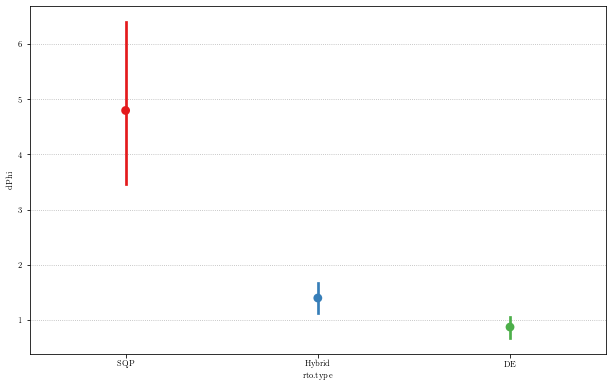

In [31]:
# data is not normal, use bootstrapping
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# sqp_bs = bs.bootstrap(data_sqp.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=True)
# de_bs = bs.bootstrap(data_de.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=True)

sqp_bs_ci = bs.bootstrap(data_sqp.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=False)
de_bs_ci = bs.bootstrap(data_de.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=False)
hyb_bs_ci = bs.bootstrap(data_hyb.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=False)

width = 5.1667 * 2
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))
sns.pointplot(data=data_last_iteration, y='dPhi', x='rto.type', palette='Set1', ax=ax)


print(sqp_bs_ci)
print(de_bs_ci)
print(hyb_bs_ci)